# <center>Universidade Federal de Minas Gerais</center>
## <center>Departamento de Ciência da Computação</center>
### <center>Projeto final: Predizendo produtos por meio de reclamações textuais</center>
<center>Ewerton Silva Santos.</center>
<center>Matricula: 2016058140.</center>
<center>ewerton_dc@hotmail.com</center>
<center>25 de Março de 2021</center>

**Resumo**: objetivo é criar um modelo Sequence-to-Sequence usando uma rede LSTM, o qual que preveja produtos financeiros por meio de uma reclamação textuais de consumidores ao "Departamento de Proteção Financeira do Consumidor" dos EUA. O corpus está disponível em https://catalog.data.gov/dataset/consumer-complaint-database. 

**Sobre o Dataset**: "The Consumer Complaint Database is a collection of complaints about consumer financial products and services that we sent to companies for response. Complaints are published after the company responds, confirming a commercial relationship with the consumer, or after 15 days, whichever comes first. Complaints referred to other regulators, such as complaints about depository institutions with less than $10 billion in assets, are not published in the Consumer Complaint Database. The database generally updates daily." [SIC]

**Baixar do GitHub**: https://github.com/EwertonDCSilv/nlp_final_project

**Executar no colab**: https://drive.google.com/drive/folders/1necRI2e-UNhp30eUqaEyp5ColWeZKN02?usp=sharing


**Link do vídeo no Drive** https://drive.google.com/drive/folders/18sVyH1lXZ9NvnQ2qMadnqUwqN-9EU92M?usp=sharing

**Link do vídeo no YouTube**  https://youtu.be/ae-_LakbDsE


------

# 1 - Introdução
<div style="text-align: justify!important"> 
<p>O processo de classificação automática de texto pode ser útil para diversos tipos de aplicação, é uma atividade que se tornou extremamente importante para empresas e usuários comuns. Este tipo de classificação pode ser utilizado para tarefas de analise de sentimentos, modelagem de tópicos, classificação de spam, verificação de notícias falsas, transcrição de áudio em texto, dentre tantas aplicações. Neste trabalho iremos tratar da predição de produtos(categórica) por meio de reclamações textuais de consumidores ao "Departamento de Proteção Financeira do Consumidor" dos EUA, utilizando-se da vetorização dos elementos textuais e suas características, para assim predizer a classe do produto financeiro em questão (Bank account,Consumer Loan, Credit card, etc). O modelo escolhido para realizar esta tarefa foi Rede Neural Recorrente (RNN) usando a arquitetura Long Short Term Memory (LSTM), sendo utilizado o dataset consumer-complaint-database, tanto para traino quanto para teste.</p>

<p>O modelo LSTM foi escolhido tento em vista sua alta capacidade de predição, fato devido principalmente a sua estrutura que permite a memorização do texto e o seu respectivo esquecimento. Além disso, o modelo permite modelar de forma simples a dependência entre os termos</p>

<p>Dada a o tratamento dos dados, a implementação do modelo, serão avaliadas, melhores escolhas de parâmetros, precisão da classificação dos produtos no geral e em especifico.</p>
</div>

In [2]:
# General
import os
import re
import nltk
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Scikit
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Keras
from keras.models import Sequential
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Dense, Embedding, LSTM, SpatialDropout1D
from IPython.display import Image 
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk import word_tokenize

# TensorFlow
from tensorflow import keras

# Graficos
%matplotlib inline
plt.rcParams['figure.figsize']  = (10, 8)
plt.rcParams['axes.labelsize']  = 12
plt.rcParams['axes.titlesize']  = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

Using TensorFlow backend.


In [3]:
plt.ion()
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 10)

### Parametros gerais e configurações

In [10]:
"""
  Definições gerais
"""
# Caminho para pasta com dados
homePath = "."

# Baixnado conjunto de stopwords
nltk.download("stopwords")

#Expressões regulares para tratamento de texto
caracterToSpace = re.compile('[/(){}\[\]\|@,;]') 
especialCacracters = re.compile('[^0-9a-z #+_]')
stopWords = set(stopwords.words('english'))

# Comprimento do texto
dimensionEmbed = 100 # Dimensão do embedding
maxWords = 50000     # Numero de palavras mais frequentes a serem utilizadas
maxSequence = 250    # Comprimento maximo da sequencia

# Parametros do modelo
epochs = 5
batch_size = 64

# Flag de treinamento
bool_train = False

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ewert\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Obtendo dataset
Dataset contendo reclamação textuais de consumidores ao "Departamento de Proteção Financeira do Consumidor" dos EUA. O dataset
 está disponível em https://catalog.data.gov/dataset/consumer-complaint-database.

In [7]:
# Dataset origim https://www.kaggle.com/sebastienverpile/consumercomplaintsdata/home
df = pd.read_csv(os.path.join(homePath,'data/Consumer_Complaints.zip'))

# Shape do dataset
print(df.shape)

# Exemplo com dados brutos
df.head()

(903983, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,3/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,3/17/2014,Closed with explanation,Yes,No,759217
1,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/5/2016,Closed with explanation,Yes,No,2141773
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100
3,6/8/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,6/10/2014,Closed with explanation,Yes,Yes,885638
4,9/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,9/13/2014,Closed with explanation,Yes,Yes,1027760


### Recortando dataset
Para realizar a tarefa de predição serão utilizadas apenas as colunas "Product"(referente ao tipo de produto) e "Consumer complaint narrative"(referente a reclamação textual). 

In [9]:
# Recortando colunas do dataframe
cutColumns = ["Product","Consumer complaint narrative"]
df = df[cutColumns]

# Removendo linhas com entradas nulas
df = df.dropna()

# Shape do dataset
print(df.shape)

df.head()

(199970, 2)


,Product,Consumer complaint narrative
1,Credit reporting,I have outdated information on my credit repor...
2,Consumer Loan,I purchased a new car on XXXX XXXX. The car de...
7,Credit reporting,An account on my credit report has a mistaken ...
12,Debt collection,This company refuses to provide me verificatio...
16,Debt collection,This complaint is in regards to Square Two Fin...


### Número de reclamações por categoria de produto

In [7]:
# Ocorrencias por tipo de produto
df.groupby("Product",as_index=None).count()

,Product,Consumer complaint narrative
0,Bank account or service,14888
1,Checking or savings account,2142
2,Consumer Loan,9474
3,Credit card,18842
4,Credit card or prepaid card,3355
5,Credit reporting,31592
6,"Credit reporting, credit repair services, or o...",14671
7,Debt collection,47915
8,"Money transfer, virtual currency, or money ser...",684
9,Money transfers,1496


### Simplificando categorias de produtos
Algumas categorias são muito similares, para que a predição não seja comprometida, algumas destas foram aglutinadas em uma categoria mais geral.

In [8]:
# Simplificando os grupos de produtos
df.loc[df['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df.loc[df['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df.loc[df['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df = df[df.Product != 'Other financial service']
df = df.reset_index(drop=True)

# 2 - Implementação
O modelo é treinado e validado utilizando apenas parte dos atributos do dataset, neste caso apenas as reclamações textuais(string) a categoria do produto (variável categórica). O dataset apresenta originalmente **18 categorias**, como algumas são extremamente similares são aglutinadas no intuito de reduzir a perda de acurácia do modelo. Outro tratamento realizado é a remoção de linhas nulas, havendo originalmente **900 mil linhas**, que se reduzem a **200 mil**. Em seguida o texto livre é sanitizado, removendo caracteres especiais e stop words, para adiante ser separado em tokens, que em seguida são convertidos para um embedding vetorial biblioteca ***Keras***, a qual também é utilizada para criação do modelo de predição. Por fim, os dados são separados em 30% para treino e 70% para teste, havendo uma ordenação aleatória das entradas.

### Tratando dados: removendo caracteres especiais e stop words

In [9]:
def sanitazeText(sentence):
    sentence = sentence.lower()                                                     # Tudo minusculo
    sentence = sentence.strip()                                                     # Remove espacos nas extremidades das strings
    sentence = caracterToSpace.sub(' ', sentence)                                   # Remove carcteres por espaco
    sentence = especialCacracters.sub('', sentence)                                 # Remove caracteres 
    sentence = sentence.replace('x', '')                                            # Remove X caracteres que ocultam dados pessoais 
    sentence = ' '.join(word for word in sentence.split() if word not in stopWords) # Removendo stop words
    return sentence

In [10]:
# Exemplo de dado sem tratamento
print("Antes:\n\n")
print("Produto",df[['Consumer complaint narrative', 'Product']].values[100][0])
print("Reclamação", df[['Consumer complaint narrative', 'Product']].values[100][1], end="\n\n")

# Aplicando funcao de limpeza de string sobre a coluna textual
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(sanitazeText)
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].str.replace('\d+', '')

# Exemplo de dado apos tratamento
print("Depois:\n\n")
print("Produto: ",df[['Consumer complaint narrative', 'Product']].values[100][0])
print("Reclamação: ", df[['Consumer complaint narrative', 'Product']].values[100][1],end="\n\n")

Antes:


Produto I recently sent a letter to this company asking for them to stop contacting me in regards to whatever it is that they keep calling me about because I have no idea what it pertains to.
Reclamação Debt collection

Depois:


Produto recently sent letter company asking stop contacting regards whatever keep calling idea pertains
Reclamação Debt collection



### Embeding

In [11]:
# Tranformando palavras em Tokens
tokenizer = Tokenizer(num_words=maxWords, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Numero de tokens distintos: ', len(word_index))

Numero de tokens distintos:  100705


### Dividindo dados de treino e teste

In [12]:
# Seprando dados
X = tokenizer.texts_to_sequences(df['Consumer complaint narrative'].values)
X = pad_sequences(X, maxlen=maxSequence)

# Seprando labels
Y = pd.get_dummies(df['Product']).values
numberClasses = len(set(df['Product']))

# Separando dados de Treino e Teste
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30, random_state = 42)

print('Dimensões do vetor de dados:', X.shape)
print('Dimensões do vetor de labels:', Y.shape)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

Dimensões do vetor de dados: (199678, 250)
Dimensões do vetor de labels: (199678, 13)
(179710, 250) (179710, 13)
(19968, 250) (19968, 13)


### Definindo estrutura do Modelo
O modelo de predição possui 4 camadas:
* **Embedding**: camada de entrada que tem por objetivo transformar inteiros positivos em vetores densos, tendo máximo 50 mil palavras para os vocabulários e 250 para dimensão dos dados. Entrada: tensor 2d; Saída: tensor 3d
* **SpatialDropout1D**: camada interna que promove a independência entre os mapas de características, realizando a remoção de forma aleatória de neurônios para evitar overfitting.  
* **LSTM**: camada interna que responsável pela longa memoria de curto prazo, a qual permite que os estados anteriores sejam utilizados para prever os estados futuros. 
* **Dense**: camada de saída, onde é executada a função de ativação para cada elemento. Tem dimensão de saída igual ao número de classes de produtos



In [13]:
# Definindo modelo usando Keras
model = Sequential()
model.add(Embedding(maxWords, dimensionEmbed, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(numberClasses, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Sumarizando modelo
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 13)                1313      
Total params: 5,081,713
Trainable params: 5,081,713
Non-trainable params: 0
_________________________________________________________________
None


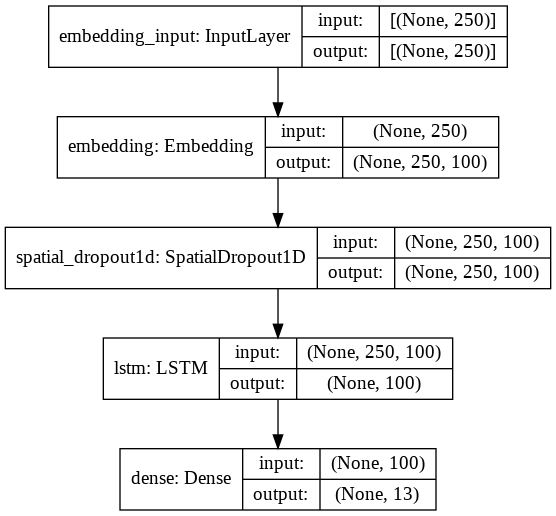

In [14]:
# Plotando modelo
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png')

### Treinando modelo

In [15]:
# Realizando treino do modelo
if bool_train is True:
  historico = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
2528/2528 [==============================] - 1859s 734ms/step - loss: 1.2792 - accuracy: 0.5937 - val_loss: 0.8927 - val_accuracy: 0.7398
Epoch 2/5
2528/2528 [==============================] - 1844s 729ms/step - loss: 0.7429 - accuracy: 0.7869 - val_loss: 0.5993 - val_accuracy: 0.8202
Epoch 3/5
2528/2528 [==============================] - 1856s 734ms/step - loss: 0.5485 - accuracy: 0.8362 - val_loss: 0.5291 - val_accuracy: 0.8373
Epoch 4/5
2528/2528 [==============================] - 1868s 739ms/step - loss: 0.4662 - accuracy: 0.8570 - val_loss: 0.4989 - val_accuracy: 0.8453
Epoch 5/5
2528/2528 [==============================] - 1876s 742ms/step - loss: 0.4103 - accuracy: 0.8727 - val_loss: 0.4937 - val_accuracy: 0.8439


### Exportando modelo treinado

In [26]:
# Exportando modelo apenas quando o treino é realizado
if bool_train is True:
  model.save(os.path.join(homePath,'model/'))

INFO:tensorflow:Assets written to: drive/MyDrive/finalProject/model/assets


### Carregando modelo ja treinado

In [11]:
# Exportando modelo apenas quando o treino é realizado
if bool_train is False:
  model = keras.models.load_model(os.path.join(homePath,'model/'))

# 3 - Analise Experimental
<p>Após a realização do teste do modelo, obtém-se uma acurácia total de 82,4%. Abaixo são exibidos os gráficos de perda e acurácia do modelo ao longo das 5 épocas, além de uma matriz de confusão para a predição de cada classe. 
</p>
<p>Pode-se observar o aumento da acurácia e a redução da perda com o aumento do número de épocas, havendo uma leve estabilização após a 4 época durante o teste</p>

In [16]:
# Calculando acuracia do modelo
acuracia = model.evaluate(X_test,Y_test)
print('Conjunto de teste\n Perda: {:0.3f}\nAcuracia: {:0.3f}'.format(acuracia[0],acuracia[1]))

624/624 [==============================] - 41s 66ms/step - loss: 0.5105 - accuracy: 0.8420
Conjunto de teste
 Perda: 0.510
Acuracia: 0.842


In [28]:
# Obtendo rotulos de predição para o teste
Y_pred  = model.predict(X_test)

### Teste: Perda do modelo

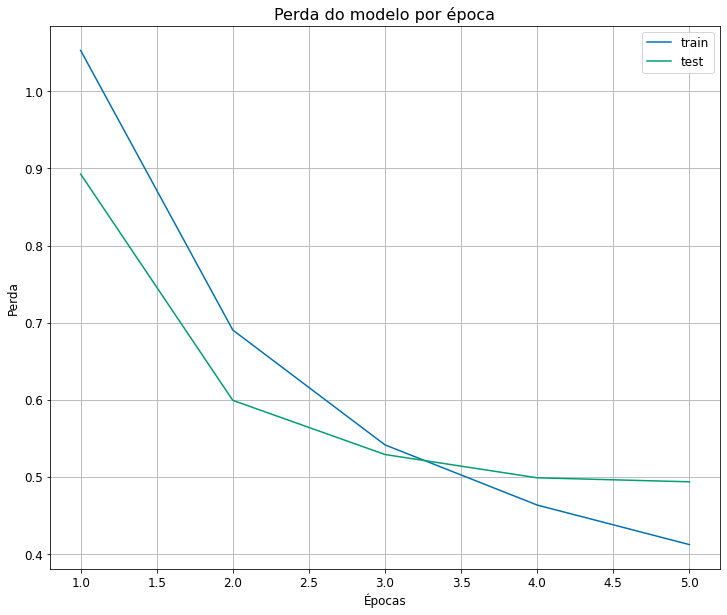

In [18]:
# Plotando perda do modelo
plt.plot(range(1,epochs+1), historico.history['loss'], label='train')
plt.plot(range(1,epochs+1), historico.history['val_loss'], label='test')
plt.title('Perda do modelo por época')
plt.xlabel("Épocas")
plt.ylabel("Perda")
plt.legend()
plt.grid()
plt.show();

### Teste: Acurácia do modelo

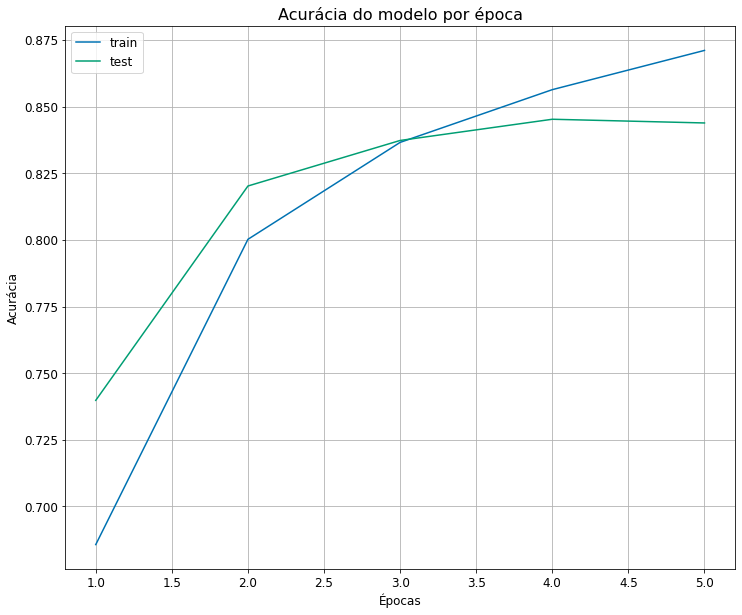

In [29]:
# Plotando acuracia do modelo
plt.plot(range(1,epochs+1), historico.history['accuracy'], label='train')
plt.plot(range(1,epochs+1), historico.history['val_accuracy'], label='test')
plt.title('Acurácia do modelo por época')
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.grid()
plt.show();

### Teste: Matriz de confusão

In [20]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
      cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)



    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [21]:
matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))   

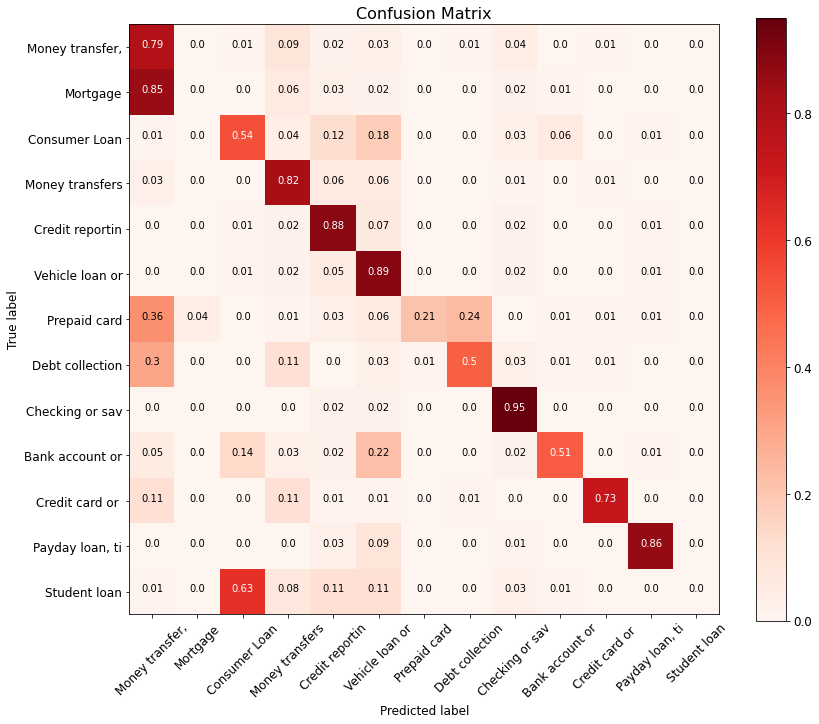

In [22]:
cm_plot_labels = list(set(df['Product']))

# Recortando label
for i  in range(len(cm_plot_labels)):
  cm_plot_labels[i] = cm_plot_labels[i][:15]

plot_confusion_matrix(cm=matrix, classes=cm_plot_labels, title='Confusion Matrix', normalize=True)

In [34]:
print(classification_report(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), target_names= set(df['Product'])))

                                                                              precision    recall  f1-score   support

                          Money transfer, virtual currency, or money service       0.73      0.79      0.76      1439
                                                                    Mortgage       0.14      0.00      0.01       229
                                                               Consumer Loan       0.73      0.54      0.62       941
                                                             Money transfers       0.81      0.82      0.81      2178
Credit reporting, credit repair services, or other personal consumer reports       0.87      0.88      0.87      4624
                                                       Vehicle loan or lease       0.83      0.89      0.86      4852
                                                                Prepaid card       0.70      0.21      0.32        67
                                                       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### Teste: predição de novas entradas

In [23]:
novaSequencia = ['The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(novaSequencia)
padded = pad_sequences(seq, maxlen=maxSequence)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

[[1.5224975e-01 6.3746148e-03 1.6479795e-03 7.4704057e-01 8.0591135e-02
  6.6144117e-03 5.3735898e-04 2.1914295e-04 2.4906443e-03 8.2800398e-05
  1.8449350e-03 2.6234894e-04 4.4328946e-05]] Credit card or prepaid card
[[1.5224975e-01 6.3746148e-03 1.6479795e-03 7.4704057e-01 8.0591135e-02
  6.6144117e-03 5.3735898e-04 2.1914295e-04 2.4906443e-03 8.2800398e-05
  1.8449350e-03 2.6234894e-04 4.4328946e-05]] Credit card or prepaid card


# 4 - Conclusão
<p>Fora analisado desemprenho do modelo LSTM para a tarefa de classificação multi-classes, avaliando parâmetros de regularização e acurácia final, que fica em 84,2%  Pelos testes realizados com a variação das 5 épocas, fica claro a limitação quando a este tipo de ajuste, que não trousse grande diferenças nas duas últimas interações.</p>